In [72]:
import ot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.base import clone
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
from utils import construct_confidence_interval

import sklearn
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler
from sklearn.model_selection import ShuffleSplit

In [73]:
from collections import Counter

In [74]:
nrows = None
random_seed = 43

In [75]:
numerical_features_index = [1, 2, 6, 12, 13]

In [76]:
data_train = pd.read_csv('../datasets/Australian Credit Approval/australian.dat', nrows=nrows, sep=' ', header=None)

y_data = data_train.loc[:, data_train.columns[-1]]
protected_attribute = data_train.loc[:, data_train.columns[0]]

data_train.drop(data_train.columns.difference(numerical_features_index), axis=1, inplace=True)
data_train = data_train.astype(np.float64)

data_train.drop_duplicates(inplace=True)

scaler = StandardScaler()

data = scaler.fit_transform(data_train)

shuffle_splitter = ShuffleSplit(n_splits=1, test_size=0.25, random_state=random_seed)

In [77]:
for train_index, test_index in shuffle_splitter.split(data):
    data_train, data_test = data[train_index], data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    protected_train, protected_test = protected_attribute[train_index], protected_attribute[test_index]
    break

In [78]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
from sklearn.model_selection import GridSearchCV

In [79]:
# clf_base = RandomForestClassifier(class_weight='balanced')#random_state=random_seed)

# param_grid = {
#     'n_estimators': [10, 50, 100, 200, 500, 1000],
#     'max_depth': [None, 2, 3, 4, 5, 6],
#     'min_samples_split': [2, 3, 4, 5]
# }

In [80]:
clf_base = GradientBoostingClassifier()

param_grid = {
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'min_samples_split': [2, 3, 4, 5],
    'max_depth':[None, 2, 3, 4, 5, 6]
}

In [81]:
# clf_base = LogisticRegression()
# param_grid = {
#     'penalty': ['l1', 'l2'],
#     'C':[0.01, 0.05, 0.1, 0.2, 0.5, 1],
# }

In [82]:
clf = GridSearchCV(clf_base, param_grid, n_jobs=-1, verbose=1, refit=True)
clf.fit(data_train, y_train)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.1min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2], 'n_estimators': [100, 200, 500, 1000], 'min_samples_split': [2, 3, 4, 5], 'max_depth': [None, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [83]:
clf_predictions = clf.predict(data_test)

In [84]:
print('Initial accuracy of classification: {}'.format(accuracy_score(y_test, clf_predictions)))
print('Initial f1 of classification: {}'.format(f1_score(y_test, clf_predictions)))

Initial accuracy of classification: 0.7514450867052023
Initial f1 of classification: 0.6906474820143884


In [85]:
negative_label = 0
positive_label = 1

In [86]:
male_entries_index = protected_train[protected_train == positive_label]
female_entries_index = protected_train[protected_train == negative_label]

male_entries_test_index = protected_test[protected_test == positive_label]
female_entries_test_index = protected_test[protected_test == negative_label]

n0 = data_train[protected_train == positive_label].shape[0]
n1 = data_train[protected_train == negative_label].shape[0]
n0_test = data_test[protected_test == positive_label].shape[0]
n1_test = data_test[protected_test == negative_label].shape[0]

emperical_histogram_male = np.ones_like(male_entries_index) / n0
emperical_histogram_female = np.ones_like(female_entries_index) / n1

emperical_histogram_male_test = np.ones_like(male_entries_test_index) / n0_test
emperical_histogram_female_test = np.ones_like(female_entries_test_index) / n1_test

In [87]:
C = ot.dist(data_test[protected_test == positive_label], data_test[protected_test == negative_label])

In [88]:
C /= C.max()

In [89]:
%%time
coupling = ot.emd(emperical_histogram_male_test, emperical_histogram_female_test, C, numItermax=1000000000)

CPU times: user 2.69 ms, sys: 0 ns, total: 2.69 ms
Wall time: 2.67 ms


In [90]:
def f(G):
    return 0.5 * np.sum(G**2)

def df(G):
    return G

In [91]:
coupling1 = ot.optim.gcg(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg1=1e-3, reg2=1e-1, f=f, df=df, verbose=True)
%time
#coupling1 = ot.stochastic.solve_semi_dual_entropic(emperical_histogram_male_test, emperical_histogram_female_test, C, reg=1, method='SAG', numItermax=100000, log=True)[0]

It.  |Loss        |Delta loss
--------------------------------
    0|2.276523e-02|0.000000e+00
    1|-1.033950e-04|-2.211773e+02
    2|-2.951189e-04|-6.496497e-01
    3|-2.967353e-04|-5.447282e-03
    4|-2.967491e-04|-4.659825e-05
    5|-2.967492e-04|-4.052508e-07
    6|-2.967492e-04|-3.573253e-09
    7|-2.967492e-04|-3.182649e-11
CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


/home/grapefroot/datascience3/lib/python3.6/site-packages/POT-0.5.1-py3.6-linux-x86_64.egg/ot/bregman.py:380: RuntimeWarning: divide by zero encountered in true_divide
  u = 1. / np.dot(Kp, v)


In [105]:
coupling1 = ot.bregman.partial_transport(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg=0.005, verbose=1, m=0.7)

It.  |Err         
-------------------
    0|4.133329e-03|
It.  |Err         
-------------------
    1|4.978536e-03|
It.  |Err         
-------------------
    2|5.424826e-03|
It.  |Err         
-------------------
    3|5.724123e-03|
It.  |Err         
-------------------
    4|5.849564e-03|
It.  |Err         
-------------------
    5|5.768303e-03|
It.  |Err         
-------------------
    6|5.729874e-03|
It.  |Err         
-------------------
    7|5.717603e-03|
It.  |Err         
-------------------
    8|5.714877e-03|
It.  |Err         
-------------------
    9|5.722733e-03|
It.  |Err         
-------------------
   10|5.596351e-03|
It.  |Err         
-------------------
   11|5.374827e-03|
It.  |Err         
-------------------
   12|5.211529e-03|
It.  |Err         
-------------------
   13|4.968735e-03|
It.  |Err         
-------------------
   14|4.696224e-03|
It.  |Err         
-------------------
   15|4.494054e-03|
It.  |Err         
-------------------
   16|4.335466e-0

In [106]:
y_first = y_test[protected_test == positive_label]
y_second = y_test[protected_test == negative_label]
print('class 0 size {}'.format(y_first.shape))
print('class 1 size {}'.format(y_second.shape))

class 0 size (107,)
class 1 size (66,)


In [107]:
from mapper import full_repair, partial_repair, random_repair_original
from utils import balanced_error_rate, disparate_impact, likelihood_ratio

In [108]:
from utils import evaluate_metrics, evaluate_repair, plot_metrics

In [109]:
from functools import partial

In [110]:
predicted_fairness_dict = {
    'DI': disparate_impact,
    'CI': partial(construct_confidence_interval, level=0.95),
}

accuracy_metrics_dict = {
    'Accuracy': accuracy_score,
}

In [111]:
from collections import defaultdict
from tqdm import tqdm

In [112]:
partial_repair_func = lambda rv, c0, c1, y0, y1: partial_repair(rv, c0 ,c1, coupling, y0, y1)
random_repair_func = lambda rv, c0, c1, y0, y1: random_repair_original(c0, c1, coupling, y0, y1, theta=rv)
partial_repair_reg_func = lambda rv, c0, c1, y0, y1: partial_repair(rv, c0 ,c1, coupling1, y0, y1)
random_repair_reg_func = lambda rv, c0, c1, y0, y1: random_repair_original(c0, c1, coupling1, y0, y1, theta=rv)

In [113]:
evaluation_1 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test, partial_repair_func, clf, predicted_fairness_dict, accuracy_metrics_dict, name='full ot')

100%|██████████| 100/100 [00:01<00:00, 79.11it/s]


In [114]:
evaluation_2 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test, random_repair_func, clf, predicted_fairness_dict, accuracy_metrics_dict, n_trials=100, name='random repair full ot')#

100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


In [115]:
evaluation_3 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test, partial_repair_reg_func, clf, predicted_fairness_dict, accuracy_metrics_dict, name='entropically regularized ot')

100%|██████████| 100/100 [00:01<00:00, 81.22it/s]


In [116]:
evaluation_4 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test, random_repair_reg_func, clf, predicted_fairness_dict, accuracy_metrics_dict, n_trials=100, name='random repair regularized ot')

100%|██████████| 100/100 [01:56<00:00,  1.16s/it]


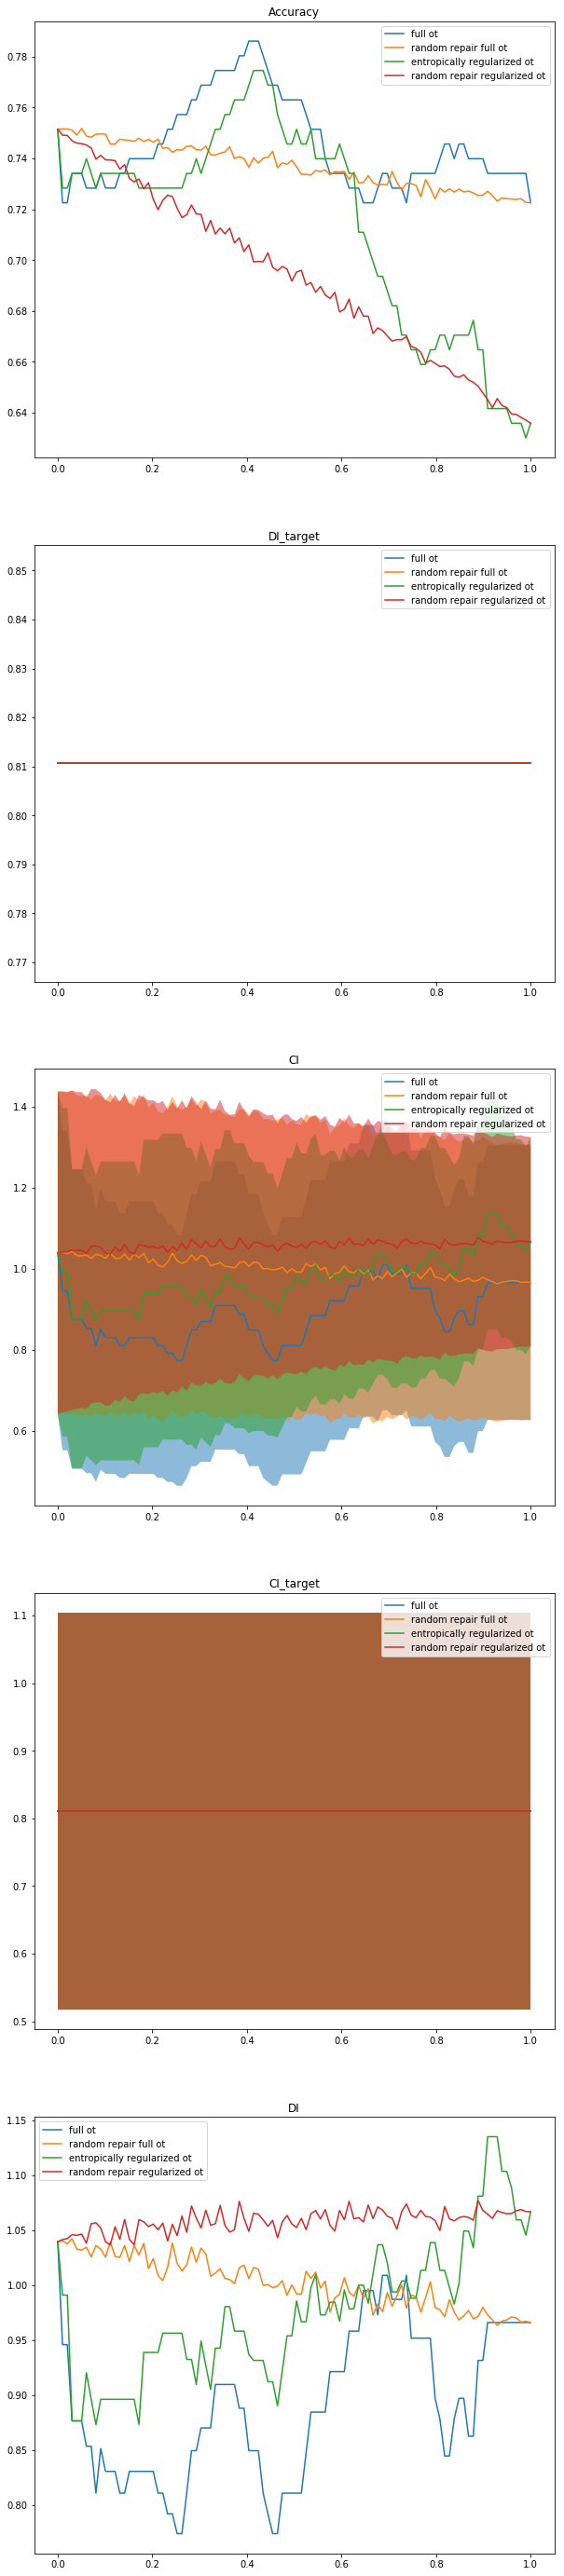

In [117]:
plot_metrics([evaluation_1, evaluation_2, evaluation_3, evaluation_4])